Exploratory analysis

In [1]:
# import packages

import pandas as pd
import os
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# load directories for reading/writing files
thedir = os.getcwd()
datadir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/raw'))
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
figdir=os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

# get list of files and number of files to load
files = os.listdir(datadir)
loggers=len(files)

In [2]:
# Load files into list of dataframes
# Get minimum length of observations so all data runs through same timeframe
# rename columns with logger names
mylist = []
mylength = []
for i in files:
    a = pd.read_csv(F"{datadir}/{i}",header =1)
    mylength.append(len(a))
    log = i[:7]
    a = a.iloc[:,[0,1,2]]
    mapping = {a.columns[0]: F"number_{log}", a.columns[1]: F'dt_{log}',a.columns[2]:log}
    a.rename(columns=mapping,inplace = True)
    mylist.append(a)
min_length= min(mylength)

## cut all dfs to same size,remove faulty obs of shortest df
newlist = []
for i in mylist:
    newdf = i.iloc[:min_length-4,:]
    newlist.append(newdf)

## concatenate along columns to create new df.
df = pd.concat(newlist,axis = 1)

# convert date time
df["time"] = pd.to_datetime(df.dt_Log_201,format = '%d/%m/%y %H:%M:%S')

#mark days
df["mon_day"] = df.time.dt.to_period("d")

## extract only relevant columns data
cols = ['mon_day','time']
for i in df.columns:
    if i[:3] == "Log":
        cols.append(i)
temps_ = df[cols].copy()

# write to csv
temps_.to_csv(F"{writedir}/alldata.csv")

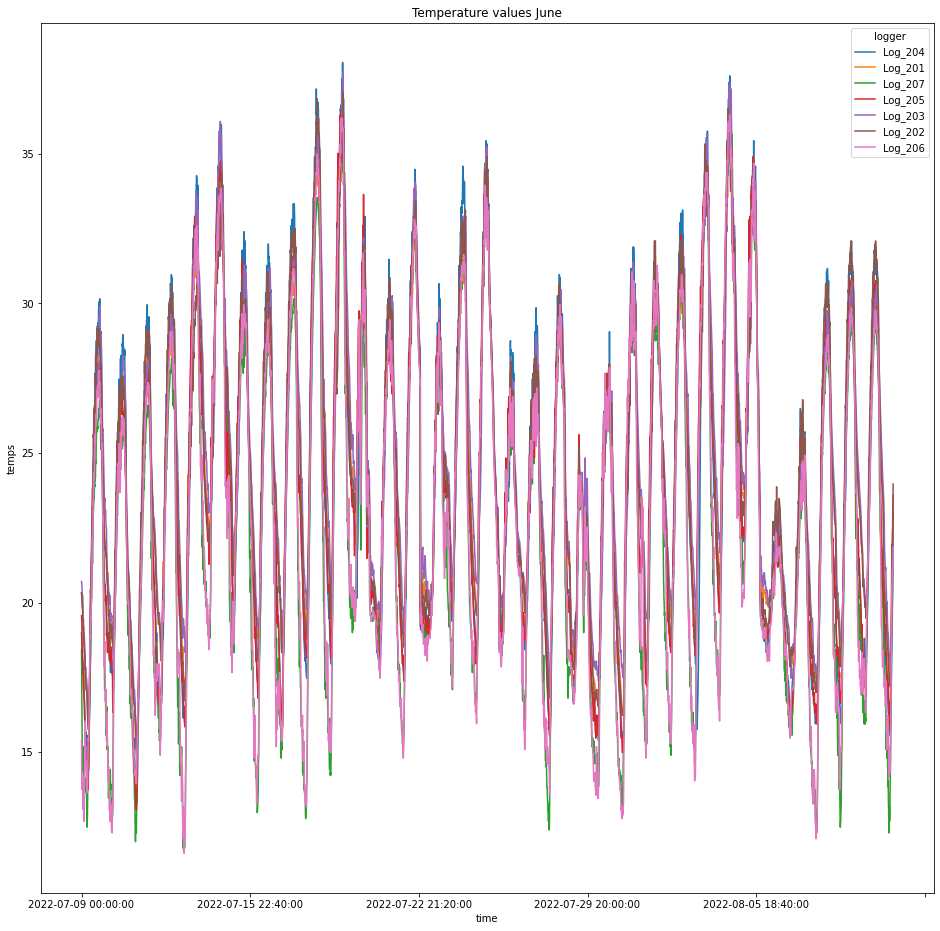

In [3]:
# lineplot of all values
log_cols = [ x for x in temps_.columns if x[:3] == "Log" ]
log_cols.append("time")
mydata = temps_[log_cols]
mydata_m = mydata.melt('time', var_name='logger', value_name='temps')
fix,ax = plt.subplots(figsize = (16,16))
sns.lineplot(data=mydata_m, x=mydata_m.time.astype(str),y='temps',hue = 'logger')
ax.set_title("Temperature values June")
ax.xaxis.set_major_locator(ticker.AutoLocator())

In [4]:
## aggregate by daily values (max, min, mean, var)
log_cols = [ x for x in temps_.columns if x[:3] == "Log" ]

#create dictionaries for use in aggregation
maxl = ["max"]*loggers
minl = ["min"]*loggers
meanl = ["mean"]*loggers
varl = ["var"]*loggers
max_ = dict(zip(log_cols,maxl))
min_ = dict(zip(log_cols,minl))
mean_ = dict(zip(log_cols,meanl))
var_ = dict(zip(log_cols,varl))

# agg by daily values
daily_max = temps_.groupby(["mon_day"]).agg(max_)
daily_min = temps_.groupby(["mon_day"]).agg(min_)
daily_mean = temps_.groupby(["mon_day"]).agg(mean_)
daily_var = temps_.groupby(["mon_day"]).agg(var_)
daily_max.reset_index(inplace=True)
daily_min.reset_index(inplace=True)
daily_mean.reset_index(inplace=True)
daily_var.reset_index(inplace=True)
log_cols.append("mon_day")

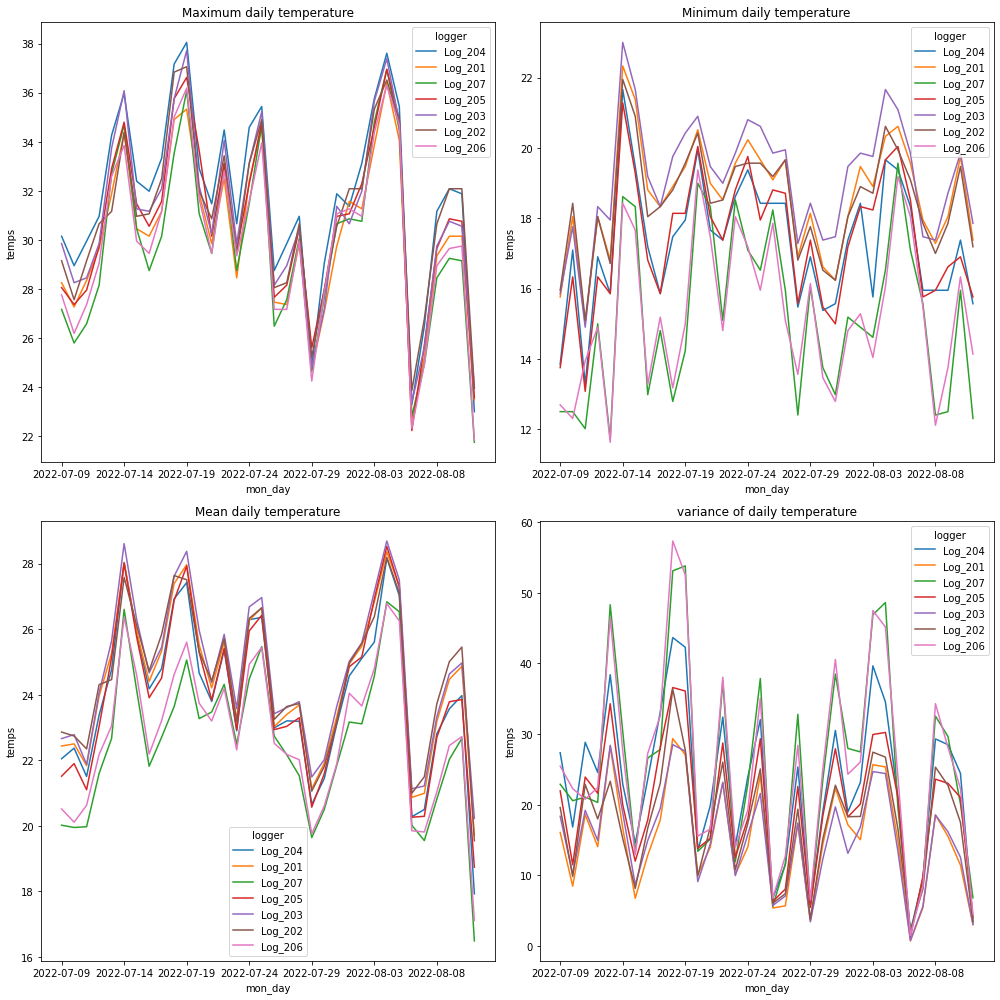

In [5]:
# plot the max, min, var, and mean temp for each station

fig, axs = plt.subplots(2,2,figsize=(14,14))
mydata = daily_max[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
a=sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax=axs[0,0])
axs[0,0].set_title("Maximum daily temperature")
axs[0,0].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_min[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[0,1])
axs[0,1].set_title("Minimum daily temperature")
axs[0,1].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_mean[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[1,0])
axs[1,0].set_title("Mean daily temperature")
axs[1,0].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_var[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[1,1])
axs[1,1].set_title("variance of daily temperature")
axs[1,1].xaxis.set_major_locator(ticker.AutoLocator())
plt.tight_layout()
plt.savefig(F"{figdir}/summary.png",bbox_inches='tight', dpi = 500)
plt.show()

In [6]:
# rural means
temps_['mean_rural'] = (temps_.Log_206 + temps_.Log_207)/2
temps_['mean_urban'] = (temps_.Log_201 + temps_.Log_202 + temps_.Log_203+ temps_.Log_204+ temps_.Log_205)/5
temps_['mean_parks'] = (temps_.Log_204 + temps_.Log_205)/2

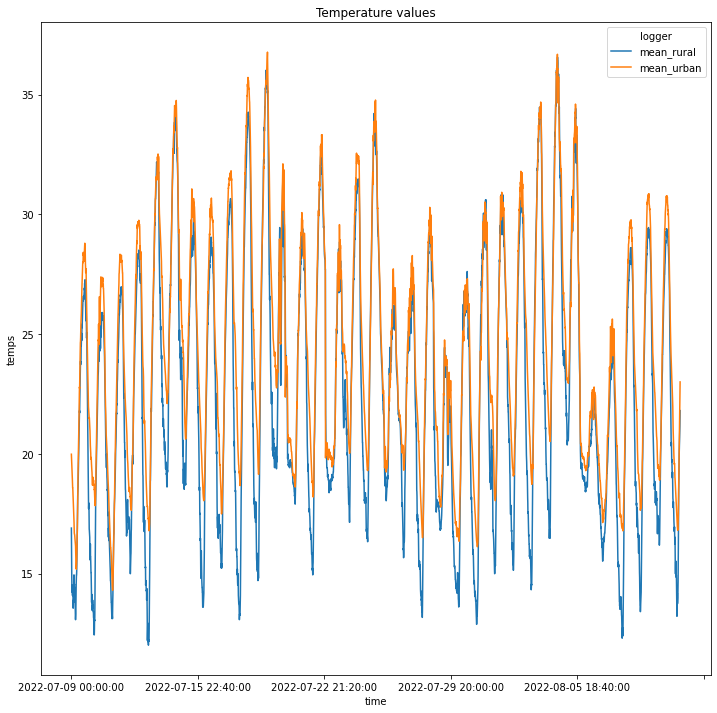

In [7]:
fig,ax = plt.subplots(figsize = (12,12))
mydata = temps_[['mean_rural','mean_urban','time']]
mydata_m = mydata.melt('time', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m,x=mydata_m.time.astype(str),y = mydata_m.temps, hue = mydata_m.logger)
ax.set_title("Temperature values")
ax.xaxis.set_major_locator(ticker.AutoLocator())
plt.show()

In [8]:
temps_['mean_urban'] = (temps_.Log_201 + temps_.Log_202 + temps_.Log_203)/3
temps_['mean'] = temps_.mean(numeric_only=True,axis = 1)
log_cols = [ x for x in temps_.columns if x[:4] == "mean" ]
length = 4
#create dictionaries for use in aggregation
maxl = ["max"]*length
minl = ["min"]*length
meanl = ["mean"]*length
varl = ["var"]*length
max_ = dict(zip(log_cols,maxl))
min_ = dict(zip(log_cols,minl))
mean_ = dict(zip(log_cols,meanl))
var_ = dict(zip(log_cols,varl))

# agg by daily values
daily_max = temps_.groupby(["mon_day"]).agg(max_)
daily_min = temps_.groupby(["mon_day"]).agg(min_)
daily_mean = temps_.groupby(["mon_day"]).agg(mean_)
daily_var = temps_.groupby(["mon_day"]).agg(var_)
daily_max.reset_index(inplace=True)
daily_min.reset_index(inplace=True)
daily_mean.reset_index(inplace=True)
daily_var.reset_index(inplace=True)
log_cols.append("mon_day")
log_cols

['mean_rural', 'mean_urban', 'mean_parks', 'mean', 'mon_day']

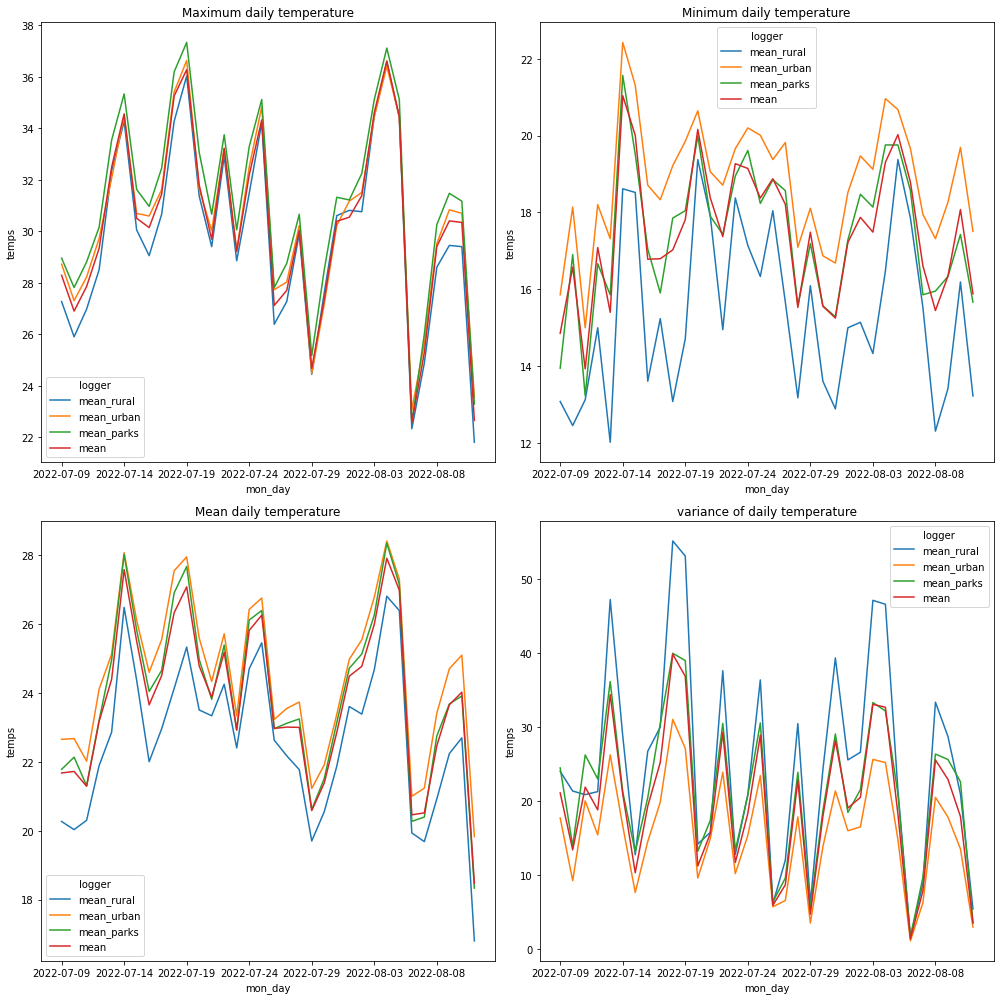

In [9]:
# plot the max, min, var, and mean temp for each station
fig, axs = plt.subplots(2,2,figsize=(14,14))
mydata = daily_max[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
a=sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax=axs[0,0])
axs[0,0].set_title("Maximum daily temperature")
axs[0,0].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_min[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[0,1])
axs[0,1].set_title("Minimum daily temperature")
axs[0,1].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_mean[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[1,0])
axs[1,0].set_title("Mean daily temperature")
axs[1,0].xaxis.set_major_locator(ticker.AutoLocator())
mydata = daily_var[log_cols]
mydata_m = mydata.melt('mon_day', var_name='logger', value_name='temps')
sns.lineplot(data=mydata_m, x=mydata_m['mon_day'].astype(str),y='temps',hue = 'logger',ax = axs[1,1])
axs[1,1].set_title("variance of daily temperature")
axs[1,1].xaxis.set_major_locator(ticker.AutoLocator())
plt.tight_layout()
plt.savefig(F"{figdir}/summary_grouped.png",bbox_inches='tight', dpi = 500)
plt.show()